<a href="https://colab.research.google.com/github/jchamilton75/UniversiteOuverte/blob/main/UO_2024_2_R%C3%A9ponses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 2 - Cosmologie avec les supernovae de type Ia


Bienvenue dans ce deuxième travail pratique en cosmologie. Aujourd'hui, nous commencerons à analyser des données réelles de cosmologie : les supernovae de type Ia. Le but de ce cahier est de reproduire par vous-même la découverte d'une constante cosmologique non nulle qui a été faite en 1998 et qui a conduit au prix Nobel de physique pour Saul Perlmutter, Brian Schmidt et Adam G. Riess.

Nous aborderons les sujets suivants :

Téléchargement, tracé des données des supernovae de type Ia (données réelles) et test par rapport à des modèles cosmologiques emblématiques.
Ajustement des meilleurs paramètres cosmologiques aux données en utilisant un ajustement direct.
Exploration de l'espace des paramètres en utilisant les chaînes de Markov Monte-Carlo afin de calculer des contraintes statistiquement significatives et précises sur les paramètres cosmologiques à partir des mêmes données.
Vous apprendrez sur :

La physique des supernovae, les magnitudes et le module de distance, qui sont des quantités observationnelles très couramment utilisées en astrophysique.
Les statistiques bayésiennes et les chaînes de Markov Monte-Carlo, qui sont devenus des outils essentiels dans l'analyse moderne des données, en particulier en cosmologie.

Avant de faire quoi que ce soit, nous exécuterons d'abord les quelques lignes de code nécessaires ainsi que le chargement de la bibliothèque cosmolib.

In [1]:
import sys
print("Using Python {}".format(sys.version_info[0]))

from pylab import *
import numpy as np
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)
!pip install emcee
!pip install iminuit
!rm -rf cosmolib.py*
!wget --no-check-certificate https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/cosmolib.py
import cosmolib as cs

Using Python 3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.9/424.9 kB 3.5 MB/s eta 0:00:00
--2024-02-28 08:40:51--  https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/cosmolib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15813 (15K) [text/plain]
Saving to: ‘cosmolib.py’

cosmolib.py         100%[===================>]  15.44K  --.-KB/s    in 0s      

2024-02-28 08:40:51 (55.3 MB/s) - ‘cosmolib.py’ saved [15813/15813]



In [34]:
from importlib import reload
reload(cs)

<module 'cosmolib' from '/content/cosmolib.py'>

# Analyse cosmologique avec les supernovae de type Ia
Nous n'allons pas détailler tout ce qui concerne les supernovae ici, mais simplement rappeler quelques éléments de base.

## Qu'est-ce que les Supernovae ?
Les supernovae sont des étoiles qui "apparaissent" soudainement dans le ciel et restent très lumineuses pendant quelques semaines à quelques mois. Certaines supernovae historiques étaient même visibles pendant la journée. Les astronomes ont peu à peu compris qu'il s'agissait d'étoiles terminant leur vie dans une explosion gigantesque. Leur luminosité est typiquement 1 milliard de fois plus grande que celle de l'étoile initiale, de sorte qu'elles sont visibles sur des distances cosmologiques (jusqu'à z=1 en général, bien que certaines soient même plus éloignées grâce au télescope spatial Hubble).

Avec le développement de l'astronomie spectroscopique, les astronomes ont réalisé que toutes les supernovae n'étaient pas spectroscopiquement identiques, elles présentaient différentes lignes d'émission et d'absorption indiquant une composition chimique très différente. De nos jours, deux mécanismes différents pour les explosions de supernovae ont été reconnus et la classification des supernovae est faite sur la base de ces mécanismes plutôt que sur les caractéristiques spectrales :

L'Effondrement de cœur correspond à l'effondrement gravitationnel d'une étoile très massive (donc jeune car la durée de vie d'une étoile est inversement proportionnelle à sa masse à la puissance 2,5). Les couches externes de gaz tombent sur les couches internes provoquant un rebond et une combustion nucléaire du matériau. C'est l'explosion. Ces supernovae sont classées spectroscopiquement comme de type II, Ib ou Ic en fonction de leurs caractéristiques spectrales.
Les Supernovae de type Ia correspondent à l'explosion d'une naine blanche dans un système binaire dans lequel le compagnon est significativement moins dense et est progressivement dévoré par le puits de potentiel gravitationnel de la naine blanche. Au-delà d'une masse de 1,44 $M_\bigodot$ (la masse de Chandrasekhar), la naine blanche n'a plus assez de pression quantique pour retenir les couches externes. En conséquence, les couches externes s'effondrent et provoquent un rebond et une explosion nucléaire.

## Bougies standard
En ce qui concerne les supernovae de type Ia, le même type d'objet simple explose (une naine blanche à la masse de Chandrasekhar). On s'attend donc à ce que l'explosion soit très reproductible d'une supernova de type Ia à une autre. En pratique, les supernovae de type Ia à leur luminosité maximale sont en effet les meilleures bougies standard connues en cosmologie avec une dispersion de leur luminosité absolue typiquement de 12% (après certaines corrections). Elles peuvent donc être utilisées pour mesurer les distances à travers l'Univers.

En utilisant les supernovae de type Ia en 1997, deux équipes ont découvert l'accélération de l'expansion de l'Univers, ce qui est généralement interprété dans les modèles de Friedman-Lemaître-Robertson-Walker comme l'effet d'une constante cosmologique.

## L'échantillon Union 2.1
Nous allons refaire cette analyse avec un échantillon moderne comprenant 580 supernovae découvertes et suivies avec 19 télescopes différents. Les courbes de lumière de ces supernovae ont été analysées en profondeur afin d'uniformiser photométriquement les mesures (correction des effets des différents télescopes, filtres, ...) de sorte que la luminosité au maximum soit aussi propre que possible. Cette uniformisation représente un effort d'analyse énorme que nous ignorerons complètement dans le présent notebook.

Nous utiliserons l'échantillon appelé "Union Sample 2.1" de l'article de N. Suzuki et al., ApJ 746, 85 (2012), http://arxiv.org/abs/1105.3470

Un échantillon encore plus moderne et plus grand est disponible et s'appelle JLA (Betoule et al. 2014) : http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html, vous pouvez être intéressé à le télécharger et à l'essayer si vous le souhaitez.

## Quelle observable ?
Lors de l'observation d'une supernova, on mesure sa courbe de lumière : l'évolution temporelle de sa luminosité apparente, comme dans la courbe suivante :

<img src="https://weareallinthegutter.files.wordpress.com/2010/12/supernova3b.jpg">

C'est la luminosité au maximum qui constitue une bougie standard avec une magnitude absolue de $M_v=-19.3 \pm 0.12$

La magnitude absolue est définie par la magnitude de l'objet s'il était situé à 10 parsecs de distance:
$$ M = -2.5 \log_{10} L(10\mathrm{pc})$$

La magnitude apparente, en revanche, est mesurée à la distance réelle *d* (en parsecs) :
$$ m = -2.5 \log_{10} L(d [\mathrm{pc}])$$
et la luminosité à la distance *d* est bien sûr :
$$ L(d) = \frac{L(10)}{(d/10)^2}$$

Étant donné que nous mesurons des luminosités, les distances cosmologiques que nous devons utiliser ici sont les **distances de luminosité**.
On peut donc définir le **module de distance** comme ::
$$\mu \equiv m-M=5\log_{10} D_L - 5$$
(avec $D_L$ supposé être en parsecs dans cette formule). Il s'agit donc d'une mesure logarithmique directe de la distance de luminosité. C'est la quantité utilisée en cosmologie.

Pour chaque supernova, on mesure la magnitude apparente au maximum, on déduit son module de distance (ce qui nécessite beaucoup d'efforts qui seront ignorés ici). D'autre part, une mesure du décalage vers le rouge de la supernova est effectuée à l'aide d'un spectre de l'objet (c'est la partie facile - notez que nous n'avons pas discuté du processus de découverte des supernovae qui est en soi très difficile car ce sont des objets rares : typiquement une par galaxie et par siècle).

Le diagramme de Hubble des SNIa est donc la représentation simple de $\mu$ en fonction de $z$ et nous savons que cette quantité dépend directement des paramètres cosmologiques car:
$$D_L(z) = c\times(1+z)\times\int_0^z \frac{1}{H(z')}dz'$$
avec
$$ H(z) = H_0\times\sqrt{\Omega_k\times(1+z)^2+\Omega_m\times(1+z)^3+\Omega_\Lambda}$$

## Remarque importante
La luminosité absolue des supernovae dépend de la distance déduite des supernovae utilisées pour la calibrer. Elle dépend donc de la constante de Hubble et enfin, la distance de luminosité dépend de la constante de Hubble de la même manière, de sorte que finalement la valeur de la constante de Hubble disparaît dans le module de distance $m-M$. Cela signifie que les supernovae sont insensibles à la constante de Hubble et ne peuvent pas être utilisées pour la contraindre seule.

## Téléchargez le fichier depuis GitHub :

In [4]:
!rm -f union2.1.txt
!wget --no-check-certificate https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/Data/union2.1.txt
! ls -lrt

--2024-02-28 08:51:01--  https://raw.githubusercontent.com/jchamilton75/CS-ST4-Cosmo-2020/master/Data/union2.1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘union2.1.txt’

union2.1.txt        100%[===================>]  33.10K  --.-KB/s    in 0.003s  

2024-02-28 08:51:01 (11.6 MB/s) - ‘union2.1.txt’ saved [33899/33899]

total 60
drwxr-xr-x 1 root root  4096 Feb 26 14:27 sample_data
-rw-r--r-- 1 root root 15813 Feb 28 08:40 cosmolib.py
drwxr-xr-x 2 root root  4096 Feb 28 08:40 __pycache__
-rw-r--r-- 1 root root 33899 Feb 28 08:51 union2.1.txt


### Lecture du fichier
Le fichier, au format ASCII, se trouve dans le répertoire Data. Il contient 5 colonnes pour chaque supernova :

le nom de la supernova
son décalage vers le rouge
son module de distance
l'incertitude sur le module de distance
une quantité non pertinente ici (la probabilité que la SNIa ait explosé dans une galaxie de faible masse) liée aux systèmes.

On lit le fichier en utilisant la commande numpy `np.loadtxt()`. qui est très pratique et renvoie les colonnes qui nous intéressent sous forme de tableaux :

In [5]:
filename='union2.1.txt'
zsn,musn,dmusn=np.loadtxt(filename,usecols=(1,2,3),unpack=True)

Regardons les dix premières lignes du fichier :

In [4]:
for i in range(10):
    print('z={0:5.3f} mu={1:6.3f} +/- {2:6.3f}'.format(zsn[i],
                                                       musn[i], dmusn[i]))

z=0.028 mu=35.347 +/-  0.224
z=0.050 mu=36.682 +/-  0.167
z=0.053 mu=36.818 +/-  0.156
z=0.070 mu=37.447 +/-  0.158
z=0.063 mu=37.483 +/-  0.156
z=0.088 mu=38.229 +/-  0.188
z=0.079 mu=37.488 +/-  0.156
z=0.017 mu=34.654 +/-  0.199
z=0.042 mu=36.336 +/-  0.167
z=0.045 mu=36.640 +/-  0.165


Nous allons maintenant tracer le module de distance des supernovae en fonction du décalage vers le rouge en incluant les barres d'erreur. Nous utiliserons la fonction 'errorbar' au lieu de 'plot' afin de tracer également les barres d'erreur. De plus, nous tracerons les données en échelle Log-Log, ce qui est préférable dans ce cas.

Text(0, 0.5, 'Distance Modulus')

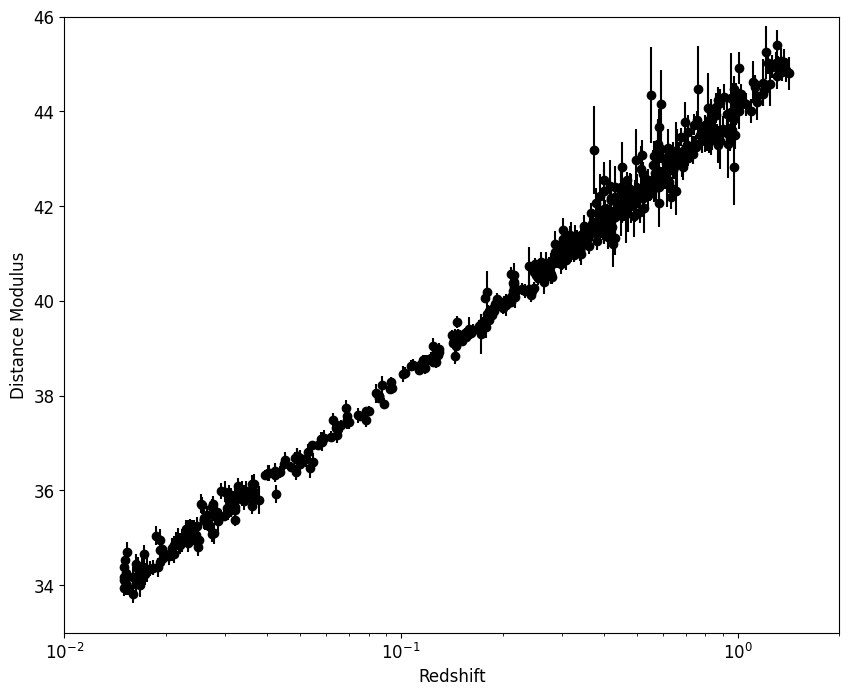

In [6]:
rc('figure',figsize=(10,8))
errorbar(zsn, musn, yerr=dmusn, fmt='ko')
xscale('log')
xlim(1e-2,2)
ylim(33,46)
xlabel('Redshift')
ylabel('Distance Modulus')

### $\chi^2$ de chaque modèle
La manière la plus courante de comparer les données et un modèle est d'utiliser la méthode des moindres carrés : on mesure la valeur d'une quantité statistique appelée $\chi^2$, qui dépend des données, de leurs incertitudes et du modèle testé par rapport aux données.

En fait, on peut facilement démontrer que pour un ensemble de données avec des barres d'erreur gaussiennes, et un modèle dépendant d'un ensemble de paramètres $f(\vec{\theta})$, minimiser le $\chi^2$ par rapport aux paramètres $\vec{\theta}$ permet de trouver les paramètres qui maximisent la probabilité que les données proviennent du modèle avec les barres d'erreur données. Cela signifie faire un "ajustement" aux données, le minimum du $\chi^2$ correspond au meilleur ajustement et est un estimateur non biaisé et optimal de $\vec{\theta}$ si les barres d'erreur sont gaussiennes.

Supposons que nous avons les données $\mu_i(z_i)$ avec des incertitudes $\sigma_i$ pour $i$ allant de $0$ à $N-1$, et un modèle $\mu_{th}(\vec{\theta}, z)$, alors le $\chi^2$ s'écrit :
$$\chi^2(\vec{\theta}) = \sum_{i=0}^{N-1} \frac{\left( \mu_i - \mu_{th}(\vec{\theta}, z_i)\right)^2}{\sigma_i^2}$$

Une interprétation naturelle et simple du $\chi^2$ (nous verrons une interprétation plus rigoureuse plus tard) est la suivante : pour chaque mesure, nous calculons la distance de cette mesure à la courbe théorique pour un ensemble de paramètres donné, et nous prenons cette distance en unités d'erreurs (nous divisons donc la distance sur l'axe des y par la barre d'erreur). Nous prenons ensuite le carré de cette quantité parce que le fait d'être au-dessus ou en dessous de la courbe ne fait pas de différence statistique (erreurs gaussiennes). Nous additionnons ensuite toutes ces quantités pour chaque point de données afin d'avoir une estimation globale de la distance de la courbe aux points. On s'attend alors à ce que plus le $\chi^2$ est petit, meilleur est l'accord de la courbe avec les points. De plus, si les barres d'erreur ont été correctement estimées et si le modèle ne surajuste pas les données, chaque $\chi^2$ individuel devrait être de l'ordre de 1 en moyenne, de sorte que le $\chi^2$ global devrait être de l'ordre de $N$ en moyenne (sur toutes les réalisations possibles). Par conséquent, en plus de l'information du $\chi^2$, on donne généralement le nombre de degrés de liberté (*ndf* pour *number of degrees of freedom*), qui est le nombre de points de données moins le nombre de paramètres qui ont été ajustés pour cette courbe. Si $\chi^2/ndf$ est trop grand, cela signifie que le modèle est mauvais ou que les incertitudes ont été sous-estimées. Si $\chi^2/ndf$ est trop faible, cela peut signifier que les barres d'erreur sont surestimées ou que le modèle surajuste les données. La valeur idéale 1 est bien sûr une moyenne et chaque réalisation fluctue autour de cette moyenne (avec une distribution de probabilité donnée par la distribution du $\chi^2$ à N degrés de liberté https://en.wikipedia.org/wiki/Chi-squared_distribution).



***Question 1:*** Vous êtes maintenant invité à superposer sur le diagramme de Hubble des supernovae les trois modèles cosmologiques canoniques différents dans trois couleurs différentes, et pour chaque modèle calculer le $\chi^2$ et le nombre de degrés de liberté de l'échantillon de données des supernovae, que vous afficherez dans la légende du graphique.

Les trois modèles cosmologiques sont bien sûr les suivants :

Plat : $h=0.7$, $\Omega_m=1$, $\Omega_\Lambda=0$, $w=-1$
Ouvert : $h=0.7$, $\Omega_m=0.3$, $\Omega_\Lambda=0$, $w=-1$
$\Lambda$CDM : $h=0.7$, $\Omega_m=0.3$, $\Omega_\Lambda=0.7$, $w=-1$
Rappelez-vous que les données SNIa ne sont PAS la distance de luminosité mais le module de distance qui est défini comme :
$$\mu \equiv m-M=5\log_{10} D_L - 5$$
(avec $D_L$ supposé être en parsecs dans cette formule).
Vous devez donc appliquer cette formule à votre distance de luminosité, vous pouvez alternativement utiliser la fonction `cs.musn1a()` qui le fait pour vous (mêmes arguments que `cs.lumdist()`).

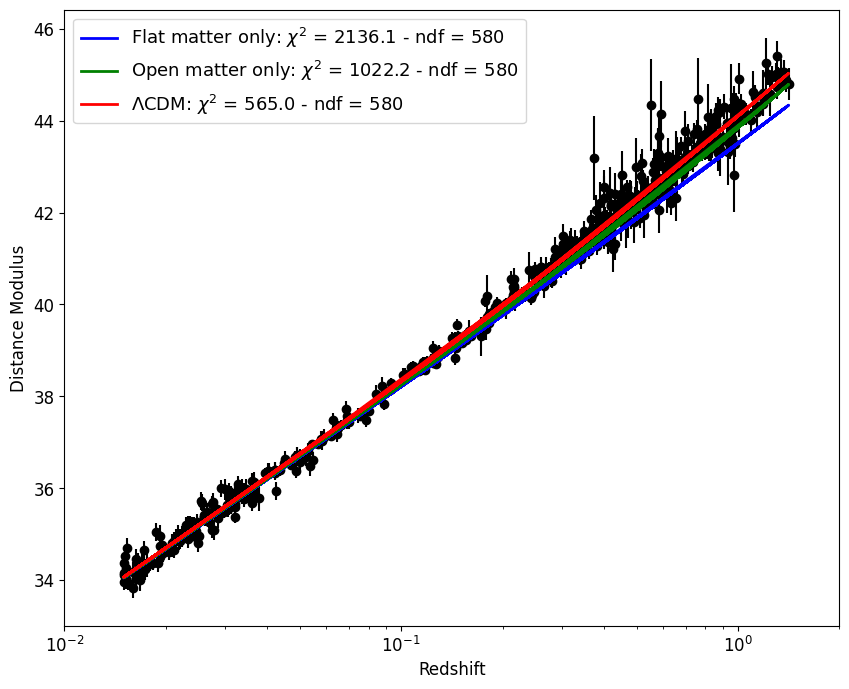

In [8]:
cosmo_lcdm = {'h':0.7, 'omega_M_0':0.3, 'omega_lambda_0':0.7, 'w0':-1.}
cosmo_flat = {'h':0.7, 'omega_M_0':1, 'omega_lambda_0':0, 'w0':-1.}
cosmo_open = {'h':0.7, 'omega_M_0':0.3, 'omega_lambda_0':0, 'w0':-1.}

### Calling cs.musn1a()
mu_flat = cs.musn1a(zsn, cosmo_flat)
mu_open = cs.musn1a(zsn, cosmo_open)
mu_lcdm = cs.musn1a(zsn, cosmo_lcdm)

### Calculating the distance modulus from luminosity distance
# mu_flat = 5*np.log10(cs.lumdist(zsn, cosmo_flat)*1e6)-5
# mu_open = 5*np.log10(cs.lumdist(zsn, cosmo_open)*1e6)-5
# mu_lcdm = 5*np.log10(cs.lumdist(zsn, cosmo_lcdm)*1e6)-5

### Chi2 calulation
chi2_flat = np.sum( (musn - mu_flat)**2/dmusn**2)
chi2_open = np.sum( (musn - mu_open)**2/dmusn**2)
chi2_lcdm = np.sum( (musn - mu_lcdm)**2/dmusn**2)

errorbar(zsn, musn, yerr=dmusn, fmt='ko',zorder=0)

zvalues = linspace(0,2,10000)
plot(zsn, mu_flat, lw=2, color='blue',
     label='Flat matter only: $\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_flat,len(zsn)))
plot(zsn, mu_open, lw=2, color='green',
     label='Open matter only: $\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_open,len(zsn)))
plot(zsn, mu_lcdm, lw=2, color='red',
     label='$\Lambda$CDM: $\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_lcdm,len(zsn)))

xscale('log')
xlim(1e-2,2)
#ylim(33,46)
xlabel('Redshift')
ylabel('Distance Modulus')
legend(loc='upper left', fontsize=13)

Vous devriez constater que le modèle $\Lambda$CDM donne un $\chi^2$ significativement meilleur et a un $\chi^2/\text{ndf}$ proche de 1, ce qui est le signe d'un bon ajustement.

***Question 1-bis:*** Vous pouvez maintenant tracer les ***résidus*** pour chaque modèle, c'est à dire la différence entre les données et le modèle:

Text(0.5, 1.0, '$\\Lambda$CDM: \n$\\chi^2$ = 565.0 - ndf = 580')

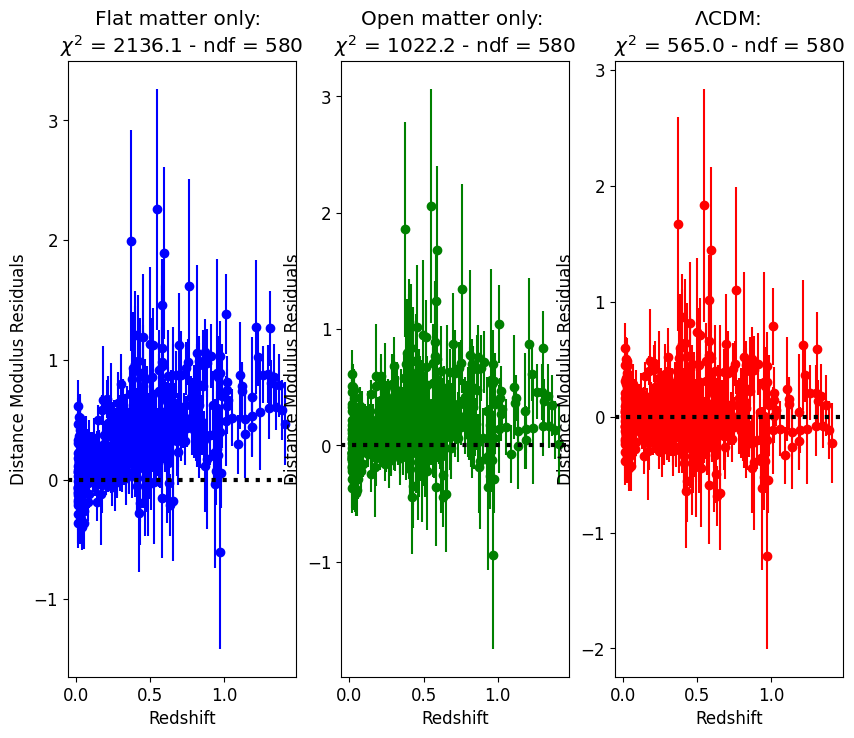

In [19]:
subplot(1,3,1)
errorbar(zsn, musn-mu_flat, yerr=dmusn, fmt='bo',zorder=0)
axhline(y=0, ls=':', color='k', lw=3)
xlabel('Redshift')
ylabel('Distance Modulus Residuals')
title('Flat matter only: \n$\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_flat,len(zsn)))

subplot(1,3,2)
errorbar(zsn, musn-mu_open, yerr=dmusn, fmt='go',zorder=0)
axhline(y=0, ls=':', color='k', lw=3)
xlabel('Redshift')
ylabel('Distance Modulus Residuals')
title('Open matter only: \n$\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_open,len(zsn)))

subplot(1,3,3)
errorbar(zsn, musn-mu_lcdm, yerr=dmusn, fmt='ro',zorder=0)
axhline(y=0, ls=':', color='k', lw=3)
xlabel('Redshift')
ylabel('Distance Modulus Residuals')
title('$\Lambda$CDM: \n$\chi^2$ = {0:5.1f} - ndf = {1:}'.format(chi2_lcdm,len(zsn)))


### Exploration brutale de l'espace des paramètres
Nous pouvons explorer l'espace des paramètres $(\Omega_m,\Omega_\Lambda)$ de manière brute pour trouver la meilleure combinaison et calculer les intervalles de confiance.

***Question 3:*** Prenez 100 valeurs pour $\Omega_m$ entre 0 et 1, 100 valeurs de $\Omega_\Lambda$ entre 0 et 1.5 et calculez le $\chi^2$ pour chacune de ces valeurs dans un tableau 2D. Vous afficherez ensuite ce tableau en ajustant la barre de couleur pour voir la forme des intervalles de confiance entre $Min(\chi^2)$ et $Min(\chi^2)+11.83$ (correspondant à 3$\sigma$).

Text(0, 0.5, '$\\Omega_\\Lambda$')

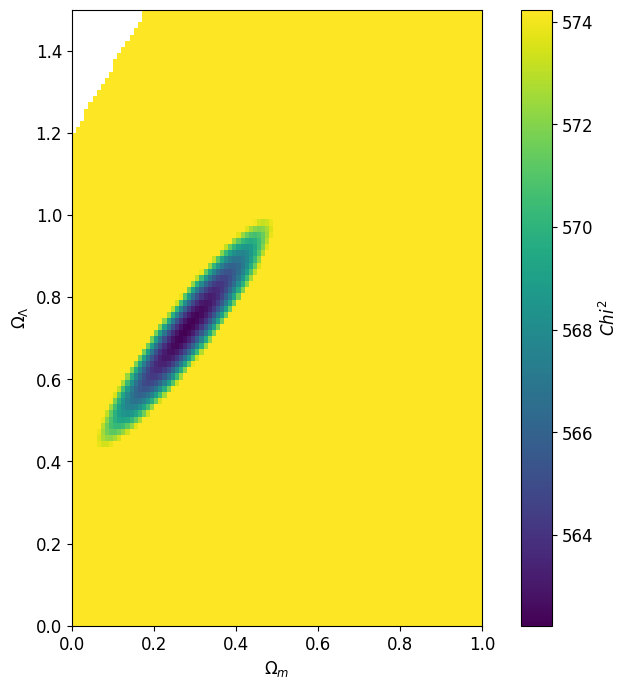

In [29]:
nn=100
omvals = np.linspace(0,1,nn)
olvals = np.linspace(0,1.5,nn)
chi2_omol = np.zeros((nn,nn))
### Double-boucle
for i in range(len(omvals)):
    for j in range(len(olvals)):
        thecosmo = {'h':0.7, 'omega_M_0':omvals[i], 'omega_lambda_0':olvals[j], 'w0':-1.}
        chi2_omol[j,i] = np.sum( (musn - cs.musn1a(zsn, thecosmo))**2/dmusn**2)

imshow(chi2_omol, origin='lower', extent=[0,1, 0, 1.5],
       vmin=np.min(chi2_omol[np.isfinite(chi2_omol)]),
       vmax=np.min(chi2_omol[np.isfinite(chi2_omol)])+12)
colorbar(label=r'$Chi^2$')
xlabel('$\Omega_m$')
ylabel('$\Omega_\Lambda$')


***Question 4:*** Maintenant, affichez la même carte de $\chi^2$ mais avec des contours à 1, 2 et 3 sigmas (correspondant en 2D à $Min(\chi^2) + 2.3$, $6.18$ et $11.83$). N'oubliez pas d'utiliser np.meshgrid() pour transformer vos coordonnées 1D X et Y en tableaux 2D. Nous vous suggérons d'utiliser les couleurs suivantes pour remplir les contours :
- `bleu` pour le contour $1\sigma$
- `dodgerblue` pour le contour $2\sigma$
- `deepskyblue` pour le contour $3\sigma$

Vous devriez également afficher la meilleure valeur d'ajustement dans une légende, ainsi que les emplacements de l'Univers Plat dans l'espace des paramètres (avec une ligne en pointillés noirs par exemple).

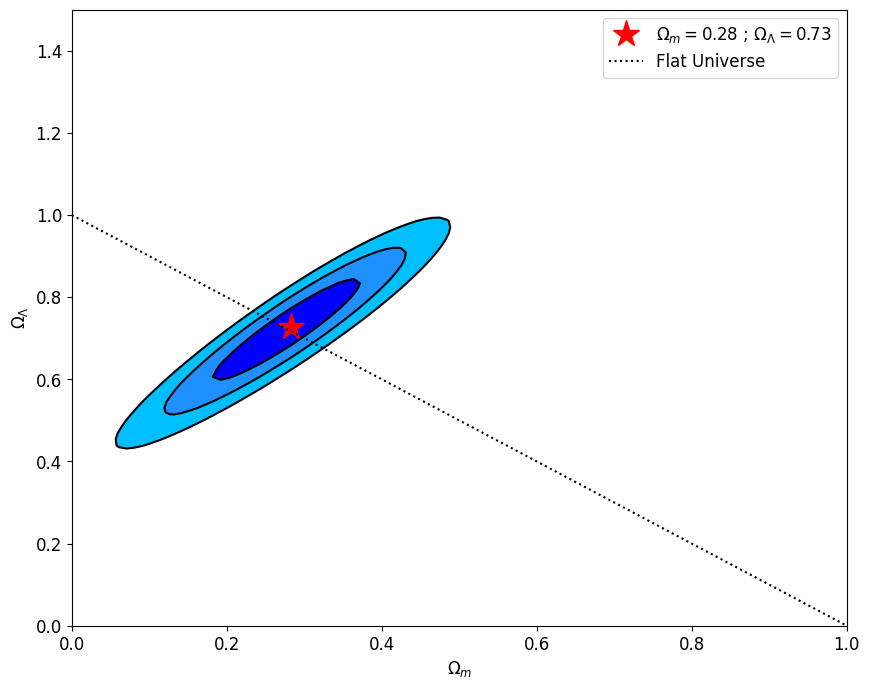

In [30]:
### On trace les contours
om2d, ol2d = np.meshgrid(omvals, olvals)
contourf(om2d, ol2d, chi2_omol, levels=[np.nanmin(chi2_omol),np.nanmin(chi2_omol)+2.3,
        np.nanmin(chi2_omol)+6.18, np.nanmin(chi2_omol)+11.83],
        colors=('blue', 'dodgerblue', 'deepskyblue'))
contour(om2d, ol2d, chi2_omol, levels=[np.nanmin(chi2_omol),np.nanmin(chi2_omol)+2.3,
        np.nanmin(chi2_omol)+6.18, np.nanmin(chi2_omol)+11.83],
        colors='k')

### On trouve le minimum
minimum = chi2_omol == np.nanmin(chi2_omol)
minom_omol = om2d[minimum]
minol_omol = ol2d[minimum]

plot(minom_omol, minol_omol, 'r*',ms=20,
     label='$\Omega_m=${0:4.2f} ; $\Omega_\Lambda=${1:4.2f}'.format(minom_omol[0], minol_omol[0]))

plot(omvals, 1.-omvals,'k:', label='Flat Universe')
xlabel('$\Omega_m$')
ylabel('$\Omega_\Lambda$')
legend(numpoints=1)

### Ajustement avec Minuit
Au lieu d'examiner les valeurs de $\chi^2$ pour des modèles individuels, nous voulons trouver le modèle le mieux ajusté, ce qui signifie minimiser le $\chi^2$. Pour cela, nous utiliserons la bibliothèque MINUIT (initialement développée au CERN dans les années 70) qui le fait de manière très efficace en utilisant un ensemble de méthodes (y compris le simple gradient conjugué) pour trouver le minimum de la surface N-dimensionnelle (N est le nombre de paramètres à ajuster). Pour simplifier, j'ai implémenté dans la bibliothèque cosmolib un simple wrapper pour Minuit qui vous évitera de plonger dans les entrailles de Minuit...

#### Première tentative avec une droite
Avant d'essayer avec les données SNIa, commençons par essayer d'ajuster une droite avec Minuit. Nous générons des points suivant une droite et ajoutons des erreurs gaussiennes :

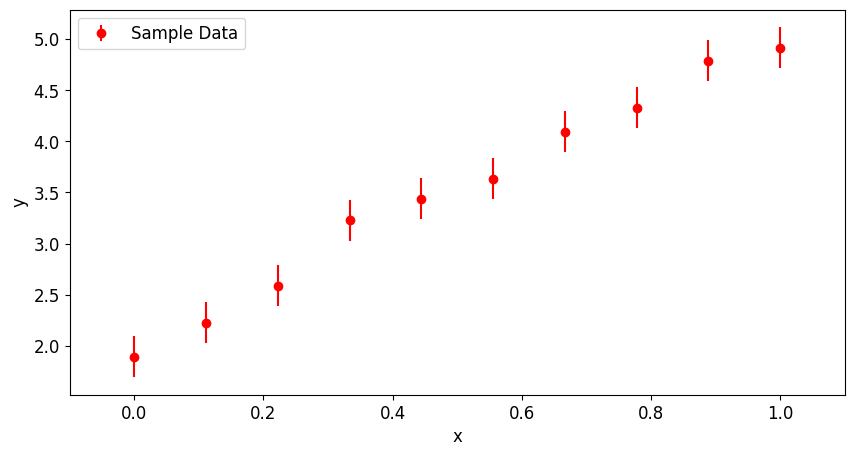

In [31]:
rc('figure',figsize=(10,5))
x = linspace(0,1,10)
sy = 0.2
y = 3*x + 2 + np.random.randn(10)*sy
sigma_y = np.zeros(10) + sy
errorbar(x,y,yerr=sigma_y,fmt='ro', label='Sample Data')
xlim(-0.1,1.1)
xlabel('x')
ylabel('y')
legend(loc='upper left')

Minuit a besoin d'un format spécifique pour la fonction à ajuster (cela s'appelle une *signature* - les noms et l'ordre des arguments de la fonction). Nous allons ajuster une fonction linéaire définie de la manière suivante :

In [32]:
def line_to_fit(x, pars):
  values = pars[0] + pars[1]*x
  return values

Maintenant, effectuons l'ajustement avec Minuit qui nécessite une estimation initiale. Trouver l'estimation initiale est parfois délicat (et peut représenter la majeure partie du travail en réalité...) mais dans le cas présent, (0,0) fonctionnera très bien. Voici ci-dessous l'appel à Minuit tel qu'implémenté dans la bibliothèque `cosmolib`.

In [33]:
guess = np.array([0., 0.])
result = cs.do_minuit(x,y,sigma_y,guess,functname=line_to_fit)

Fitting with Minuit
Chi2 = 2.8532308325348525
ndf = 8
Fitted values:
[1.96750275 3.09195249]
Errors:
[0.11755059 0.19817318]
Covariance:
[[ 0.01381814 -0.01963629]
 [-0.01963629  0.03927261]]



Analysons les résultats. La sortie de Minuit peut être comprise comme suit : elle renvoie dans une liste l'objet d'ajustement, la valeur des paramètres ajustés, leurs barres d'erreur et la matrice de covariance, puis le chi carré et le nombre de degrés de liberté. Donc, voici ces valeurs :

In [34]:
print(result[0])
print(result[1])
print(result[2])
print(result[3])
print(result[4])
print(result[5])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.853 (χ²/ndof = 0.4)      │              Nfcn = 44               │
│ EDM = 1.33e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

Finalement, nous pouvons écrire le résultat et les barres d'erreur comme suit :

In [35]:
for i in range(len(result[1])):
  print('Parameter {0:d} = {1:5.2f} +/- {2:5.2f}'.format(i, result[1][i], result[2][i]))

Parameter 0 =  1.97 +/-  0.12
Parameter 1 =  3.09 +/-  0.20


Ce qui est très cohérent avec les valeurs d'entrée. Vous pouvez réexécuter les lignes ci-dessus en modifiant le niveau de bruit, les exécuter plusieurs fois pour générer plusieurs réalisations...

Nous montrons ci-dessous les données initiales ainsi que la droite ajustée :

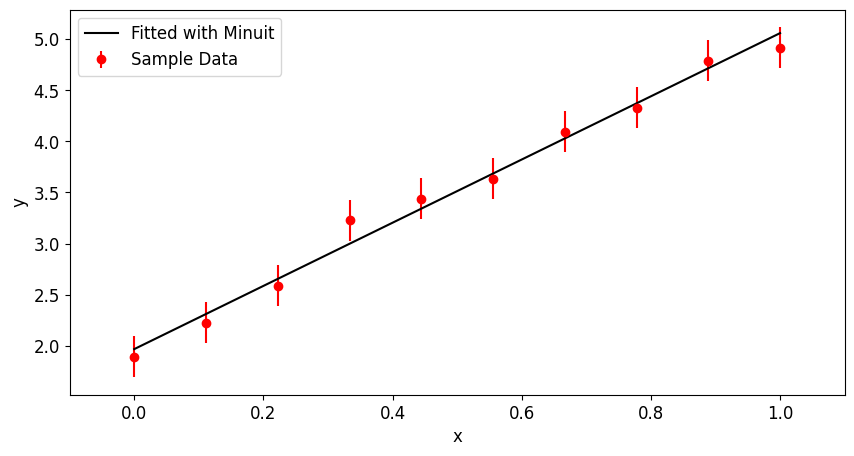

In [36]:
errorbar(x,y,yerr=sigma_y,fmt='ro', label='Sample Data')
plot(x, line_to_fit(x, result[1]),'k', label='Fitted with Minuit')
xlim(-0.1,1.1)
xlabel('x')
ylabel('y')
legend(loc='upper left')

#### Ajustement SNIa avec Minuit

Revenons aux SNIa. Comme précédemment, afin de pouvoir utiliser Minuit, la fonction d'ajustement (le modèle) doit être donnée avec une *signature* spécifique (ce qui signifie le nom et l'ordre des arguments) de la manière suivante :

In [37]:
def newmusn(x, pars):
    cosmo = {'h':pars[0], 'omega_M_0':pars[1],
             'omega_lambda_0':pars[2], 'w0':pars[3]}
    val = cs.musn1a(x, cosmo)
    val[isnan(val)] = -1e30
    return val

où `pars` est donc un tableau avec les paramètres cosmologiques. Notez que dans l'éventualité où la fonction `cs.musn1a()` devrait renvoyer une valeur indéfinie (*nan* = "Not a Number"), ce qui peut se produire pour certaines combinaisons de paramètres pour lesquelles l'intégrale de la distance propre ne converge pas, nous remplaçons ce *nan* par une valeur négative extrêmement élevée qui montrera à Minuit que cet ensemble de paramètres est vraiment mauvais, mais ne générera pas d'erreur en raison de la présence de *nan*.

L'ajustement nécessitera une estimation initiale, nous choisirons donc $$(h=0.7 ; \Omega_m=0.3 ; \Omega_\Lambda=0.7 ; w=-1)$$ Nous choisissons également de fixer certains des paramètres (avec le mot clé `fixpars` ajouté à l'appel de Minuit) :
- $H_0$ n'est pas du tout contraint par les SNIa, nous le fixons donc.
- $w$ peut être contraint par les SNIa mais nous choisissons ici de ne pas l'inclure dans l'analyse car cela complique les choses. Nous le fixons à -1.
Nous fixerons donc les variables 0 et 3 en ajoutant à l'appel de Minuit le mot clé `fixpars = [0,3]`

***Question 5 :*** Effectuez l'ajustement et imprimez les valeurs ajustées comme ci-dessus.

In [38]:
guess = np.array([0.7, 0.3, 0.7, -1.])
resfit_omol = cs.do_minuit(zsn,musn,dmusn,guess,functname=newmusn,
                           fixpars = [0,3])

for i in range(len(resfit_omol[1])):
  print('Parameter {0:d} = {1:5.2f} +/- {2:5.2f}'.format(i, resfit_omol[1][i], resfit_omol[2][i]))

Fitting with Minuit
Chi2 = 562.226681021091
ndf = 578
Fitted values:
[ 0.7         0.27853317  0.72336658 -1.        ]
Errors:
[0.007      0.06285575 0.08198288 0.01      ]
Covariance:
[[0.         0.         0.         0.        ]
 [0.         0.00395084 0.00479907 0.        ]
 [0.         0.00479907 0.00672119 0.        ]
 [0.         0.         0.         0.        ]]
Parameter 0 =  0.70 +/-  0.01
Parameter 1 =  0.28 +/-  0.06
Parameter 2 =  0.72 +/-  0.08
Parameter 3 = -1.00 +/-  0.01


Nous sommes heureux de trouver les valeurs attendues de 0,28 et 0,72 pour $\Omega_m$ et $\Omega_\Lambda$ avec un $\chi^2/\text{ndf}$ satisfaisant.

Jetez également un œil à la matrice de covariance en utilisant l'indice 3 du résultat retourné par Minuit.

Les barres d'erreur et les matrices de covariance sont une mesure utile des intervalles de confiance, mais dans le cas où ils sont complexes et non gaussiens, et en particulier lorsqu'il y a un grand nombre de dimensions, cette approche d'ajustement simple est un peu limitée. Elle ne donne que la valeur d'ajustement optimale, mais nous aimerions visualiser la forme des intervalles de confiance dans plusieurs dimensions...

C'est là que les chaînes de **Monte-Carlo Markov Chains** deviennent utiles...

### Ajustement avec des Monte-Carlo Markov-Chains


#### La vraisemblance et le $\chi^2$ (une version plus rigoureuse que ci-dessus)
Nous avons parlé du $\chi^2$ et expliqué de manière simple sa signification statistique. En réalité, le $\chi^2$ a une signification rigoureuse plus profonde que nous expliquerons ici.

Supposons à nouveau que nous avons des données $x_i$, $y_i$ pour $i$ allant de 0 à $N-1$, chacune avec une incertitude $\sigma_i$. Nous avons un modèle physique pour décrire nos mesures $y=f(x,\vec{\theta})$ où $\vec{\theta})$ sont les paramètres du modèle (que nous voulons déterminer). Chaque $y_i$ doit donc être tiré de manière aléatoire à partir de $f(x_i,\vec{\theta})$ avec un bruit dont la distribution statistique sera supposée être une gaussienne (c'est l'hypothèse importante ici).

On peut donc écrire l'équation suivante pour toutes les valeurs de $i$ :
$$y_i = f(x_i,\vec{\theta}) - n_i$$
où $n_i$ est un nombre aléatoire avec une distribution gaussienne centrée sur 0 et une variance $\sigma_i$, donc :
$$P(n_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left( -\frac{n_i^2}{2\sigma_i^2}\right)$$
ce qui peut être réécrit comme la probabilité de mesurer nos données $d_i=(x_i,y_i)$ étant donné un ensemble de paramètres $\vec{\theta}$ :
$$P(d_i \mid \vec{\theta}) = \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left( -\frac{\left(y_i-f(x_i,\vec{\theta})\right)^2}{2\sigma_i^2}\right)$$

La probabilité globale de l'ensemble des données est le produit de toutes les probabilités individuelles :
$$P(\vec{d} \mid \vec{\theta}) = \prod_{i=0}^{N-1} \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left( -\frac{\left(y_i-f(x_i,\vec{\theta})\right)^2}{2\sigma_i^2}\right)$$
Il est alors facile d'échanger le produit et l'exponentielle, et nous renommons cette probabilité exprimée de cette manière comme la **vraisemblance** des données et du modèle :
$$\cal{L}(\vec{d} \mid \vec{\theta}) =  \frac{1}{\prod_{i=0}^{N-1}\sqrt{2\pi\sigma_i^2}} \exp\left( \sum_{i=0}^{N-1}-\frac{\left(y_i-f(x_i,\vec{\theta})\right)^2}{2\sigma_i^2}\right)$$

Le meilleur ensemble de paramètres $\hat{\vec{\theta}}$ est celui qui maximise cette vraisemblance $\cal{L}$. Il minimise donc également la quantité suivante :
$$
\begin{eqnarray}
A(\vec{d} \mid \vec{\theta}) &=& -2\log\left(\cal{L(\vec{d} \mid \vec{\theta})}\right)\\
&=& -2\log\left( \frac{1}{\prod_{i=0}^{N-1}\sqrt{2\pi\sigma_i^2}}\right) +\sum_{i=0}^{N-1}\frac{\left(y_i-f(x_i,\vec{\theta})\right)^2}{\sigma_i^2}
\end{eqnarray}$$
Le premier terme ne dépend pas des paramètres $\vec{\theta}$ et ne joue donc aucun rôle dans la minimisation. Le deuxième terme est exactement le $\chi^2$ que nous avons utilisé jusqu'à présent. Il est donc parfaitement légitime et rigoureux d'utiliser la méthode du $\chi^2$ lorsque les barres d'erreur sont gaussiennes :
$$\chi^2(\vec{d} \mid \vec{\theta}) = \sum_{i=0}^{N-1}\frac{\left(y_i-f(x_i,\vec{\theta})\right)^2}{\sigma_i^2}$$

### Le théorème de Bayes et la *probabilité a posteriori*
Jusqu'à présent, nous avons parlé de la probabilité de mesurer $\vec{d},\vec{\sigma}_i$ si les paramètres sont $\vec{\theta}$, c'est ce qu'on appelle une vraisemblance. Évidemment, en tant que physicien, la quantité qui nous intéresse le plus est plutôt la probabilité que les paramètres soient $\vec{\theta}$ si les données sont $\vec{d},\vec{\sigma}_i$. Cette dernière quantité est appelée **postérieure**. La différence entre ces deux quantités est exprimée à travers le théorème de Bayes (https://en.wikipedia.org/wiki/Bayes%27_theorem) qui stipule que pour deux propositions statistiques interdépendantes A et B, on a :
$$P(A \mid B) = \frac{P(B\mid A)P(A)}{P(B)}$$
Dans notre cas, cela s'écrit :
$$P(\vec{\theta} \mid \vec{d}) = \frac{P(\vec{d}\mid \vec{\theta})P(\vec{\theta})}{P(\vec{d})}$$
Quelques quantités importantes apparaissent ici :
- La postérieure $P(\vec{\theta} \mid \vec{d})$
- La vraisemblance $P(\vec{d}\mid \vec{\theta})$
- La probabilité des paramètres **indépendamment** de toute connaissance des données, appelée la **prior bayésienne** $P(\vec{\theta})$
- La probabilité des données indépendamment du modèle. Celle-ci n'a pas d'intérêt particulier (elle ne dépend pas des paramètres) et est simplement associée à la normalisation globale de notre postérieure (dont l'intégrale doit être égale à 1).

Nous avons donc :
$$P(\vec{\theta} \mid \vec{d}) \propto P(\vec{d}\mid \vec{\theta})\times P(\vec{\theta})$$
Si la prior bayésienne est uniforme, alors la postérieure et la vraisemblance sont égales, sinon elles sont différentes... Notez que si l'on prend une prior uniforme pour un paramètre $a$, Cela ne correspond pas à une prior uniforme pour $a^2$, $\sqrt{a}$ ou toute fonction de $a$. Comme nous n'avons aucune raison particulière de penser que $a$ est un meilleur paramètre que toute fonction de $a$, la prior bayésienne semble être une quantité inévitable si l'on veut parler de la probabilité des paramètres donnés par les données...

Nous entrons donc ici dans le débat éternel entre les **fréquentistes** et les **bayésiens** :
- Les fréquentistes pensent qu'il n'y a aucune légitimité scientifique à utiliser une prior, et qu'il est donc impossible d'écrire une postérieure. Ils se limitent à parler uniquement de la vraisemblance : la probabilité de faire une telle mesure si les paramètres sont $\vec{\theta}$. Ils ne parleront donc jamais de la *probabilité d'un paramètre* qui leur semble sans signification. Cette approche est très légitime dans le sens où les paramètres physiques de notre Univers ne semblent pas avoir de probabilité (à moins de croire en un Multivers, un Paysage de Cordes...): ils sont ce qu'ils sont. Les variables aléatoires ne sont pas les paramètres mais les mesures.
- Les bayésiens sont sans aucun doute moins rigoureux mais pensent que le but de la science est de répondre à la question $P(\vec{\theta} \mid \vec{d})$ et non $P(\vec{d}\mid \vec{\theta})$. Il est donc nécessaire de choisir une prior et de parler de postérieures. Un scientifique doit donc gérer de manière à ce que le choix de la prior influence le résultat final de manière minimale...

Au-delà de ce débat épistémologique profond et légitime, dans la plupart des cas concrets, cela ne change rien : les bayésiens prendront souvent les résultats d'autres expériences comme prior tandis que les fréquentistes incorporeront ces résultats dans leur vraisemblance. En fin de compte, ils trouveront souvent les mêmes intervalles de confiance qui seront interprétés directement par les bayésiens comme la densité de probabilité des paramètres. Les fréquentistes diront plutôt que ces intervalles de confiance sont tels qu'ils contiennent la *vraie valeur* des paramètres dans X% des expériences que l'on aurait pu réaliser.

C'est une différence subtile mais persistante et il arrive parfois que l'une des approches fonctionne mieux que l'autre.

En pratique, les méthodes fréquentistes sont généralement plutôt compliquées à mettre en œuvre lorsque l'on a de nombreux paramètres et que l'on veut calculer/visualiser la forme exacte des intervalles de confiance et que l'on veut propager les incertitudes. Les méthodes des chaînes de Markov via Monte-Carlo sont fondamentalement bayésiennes et faciles à mettre en œuvre, et permettent une propagation des erreurs sans difficultés. Dans la plupart des cas, cet argument de simplicité conduit souvent les physiciens fréquentistes à adopter les méthodes bayésiennes habituelles...

### Méthodes des Chaînes de Markov via Monte-Carlo (MCMC)
Une méthode MCMC vise à déterminer directement la postérieure, pour ce faire, on échantillonne directement l'espace des paramètres afin de calculer la postérieure sur chaque point.

Si l'on échantillonne uniformément l'espace des paramètres, l'efficacité sera très faible : il y aura beaucoup de points échantillonnés dans la région où la probabilité est faible (ce qui nous importe peu) et relativement peu d'échantillons dans les régions à haute postérieure que nous aimerions bien échantillonner.

La solution est donc d'échantillonner l'espace des paramètres de manière non uniforme et de tirer plus d'échantillons là où la postérieure est élevée et moins là où elle est faible. Idéalement, on échantillonnerait directement l'espace des paramètres en utilisant la postérieure, ce qui revient à connaître la solution à l'avance...

En fait, il existe un algorithme magique connu sous le nom de **Metropolis-Hastings** (du nom d'une partie de ses inventeurs dans les années 50) qui permet directement de générer des nombres aléatoires et de finir avec une série de points (une chaîne de Markov) dont la distribution converge asymptotiquement vers la postérieure. Cela semble magique mais cela fonctionne réellement.
La chose la plus étonnante est peut-être que cet algorithme est très simple. Voici comment cela fonctionne :

- Commencez avec un point aléatoire dans l'espace des paramètres $\vec{\theta}_0$.
- Tire un nouveau point aléatoirement dans l'espace des paramètres $\vec{\theta}_i$.
    - Calcule le rapport de la postérieure $a=\frac{P(\vec{\theta}_i \mid \vec{d})}{P(\vec{\theta}_0 \mid \vec{d})}$.
        - Si $a\geq 1$, alors conserve le nouveau point $\vec{\theta}_1=\vec{\theta}_i$.
        - Si $a\lt 1$, tire un nombre aléatoire uniformément entre 0 et 1.
            - Si ce nombre est plus petit que $1-a$, alors ne conserve pas le nouveau point mais conserve l'ancien $\vec{\theta}_1=\vec{\theta}_0$.
            - Sinon, conserve le nouveau point $\vec{\theta}_1=\vec{\theta}_i$.
- Ensuite, recommence en tirant un nouveau $\vec{\theta}_i$.

De cette manière, on construit une série d'ensembles de paramètres $\vec{\theta}_i$ pour $i$ entre 0 et $N_{samples}$ qui auront les propriétés suivantes :
- C'est une chaîne de Markov : ($\vec{\theta}_i$ ne dépend que de son prédécesseur $\vec{\theta}_{i-1}$).
- Elle échantillonne la postérieure $P$, ce qui signifie que la densité de points dans la chaîne dans l'espace des paramètres est proportionnelle à $P(\vec{\theta} \mid \vec{d})$. Nous obtenons donc directement la forme et les statistiques de la postérieure en examinant la distribution spatiale des points dans la chaîne.

Voyons comment cela fonctionne sur un exemple simple avec une implémentation simpliste (mais correcte) de Metropolis-Hastings. Nous définissons une postérieure gaussienne centrée sur 2 avec une variance égale à 3. Ensuite, nous utilisons notre algorithme Metropolis-Hastings avec une chaîne de 10000 éléments. Idéalement, nous devrions rejeter la première partie de la chaîne qui prend du temps à "démarrer" (ceci est appelé le "Burn out"), mais nous ne le ferons pas ici afin de rester simple.

In [39]:
#### Define the posterior (we cheat here, in general its shape
#### is not known, we need to calculate it at each step in a
#### complicated and CPU consuming manner)
def like(x):
    return 1./(np.sqrt(2*np.pi)*3) * exp(-0.5*(x-2.)**2/3.**2)

#### IInitialize the chain
nbtot = 10000
chain = np.zeros(nbtot)
init = 10.

#### Run the Metropolis Hastings just as a python
#### transcription of the above
#### The jump to the next element is made in a wide manner with a random
#### number uniformly between -15 and 15
nok = 0
while nok < nbtot:
    pini = like(init)
    new = init + np.random.rand(1)*30-15
    pnew = like(new)
    a = pnew/pini
    #print(a)
    if (a>=1):
        chain[nok] = new
        init = new
        nok += 1
    else:
        rd = np.random.rand(1)
        if (rd < (1-a)):
            #print('ok')
            chain[nok] = init
            init = init
            nok += 1
        else:
            chain[nok] = new
            init = new
            nok += 1

print(chain)

<ipython-input-39-cfdc76e92000>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chain[nok] = new
<ipython-input-39-cfdc76e92000>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chain[nok] = init
<ipython-input-39-cfdc76e92000>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chain[nok] = new


[10.         -0.28283088 -0.28283088 ...  4.68641603  4.68641603
  4.68641603]


Maintenant, traçons simplement l'histogramme des valeurs échantillonnées avec la forme de la postérieure que nous avons supposée au départ :

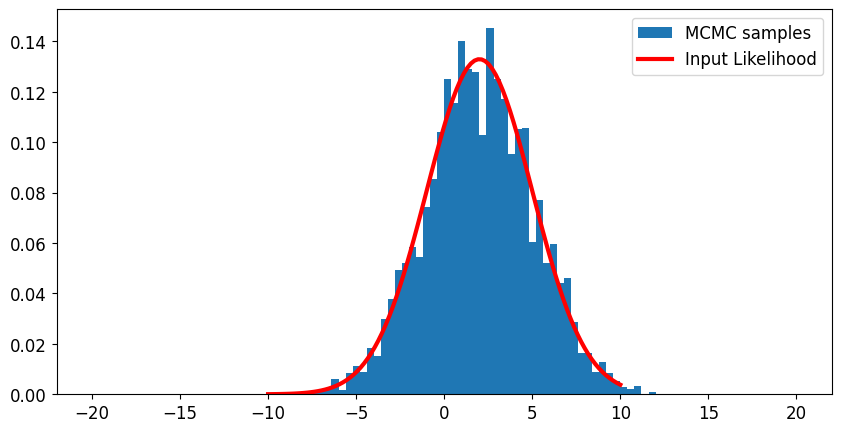

In [40]:
bla=hist(chain, bins=100,range=[-20,20], density=True, label='MCMC samples')
xx=linspace(-10,10,100)
plot(xx,like(xx),'r-',lw=3, label='Input Likelihood')
legend()

Pas mal, n'est-ce pas !

Vous pouvez essayer de l'exécuter avec plus d'éléments pour voir l'amélioration de la convergence.

L'exemple ci-dessus peut sembler un peu stupide dans le sens où nous connaissions la formule de la postérieure à l'avance... Ici, la Gaussienne. Cependant, dans la plupart des cas réalistes, la valeur de la postérieure en un point de l'espace des paramètres n'a pas d'expression analytique et nous devons la calculer d'une manière compliquée qui est généralement très gourmande en termes de processeur. Le Metropolis-Hastings permet d'échantillonner très efficacement l'espace des paramètres avec un nombre minimal d'appels à la fonction postérieure.

####
Exemple d'ajustement d'une droite
Prenons l'exemple de l'ajustement d'une droite afin d'approfondir notre compréhension de la méthode. Ce sera également l'occasion d'utiliser une version plus efficace et robuste de l'algorithme Metropolis-Hastings que j'ai préparée dans la bibliothèque `cosmolib.py` en utilisant la bibliothèque `pymc` (https://pymc-devs.github.io/pymc/).

Nous tirons les points suivants selon une loi linéaire que nous voulons ajuster :

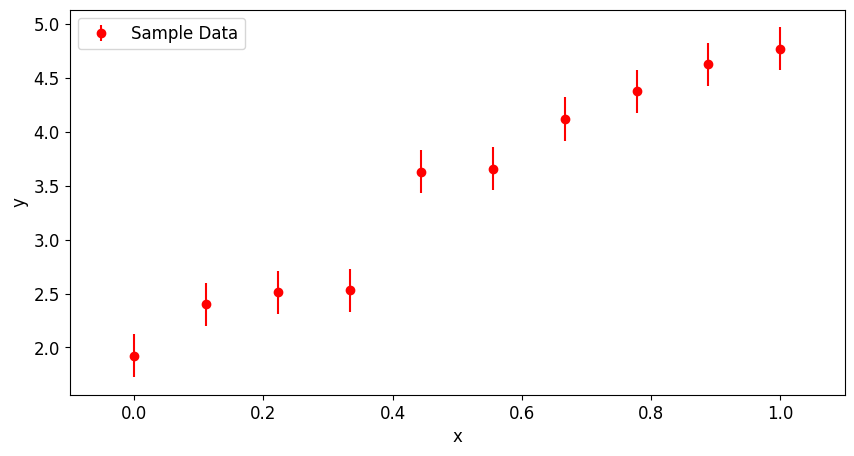

In [42]:
rc('figure',figsize=(10,5))
x = linspace(0,1,10)
sy = 0.2
y = 3*x + 2 + np.random.randn(10)*sy
sigma_y = np.zeros(10) + sy
errorbar(x,y,yerr=sigma_y,fmt='ro', label='Sample Data')
xlim(-0.1,1.1)
xlabel('x')
ylabel('y')
legend(loc='upper left')

La fonction que nous ajusterons est donnée ci-dessous. Nous préparons également une variable appelée "data" qui contient les données x, y et les erreurs ainsi que le modèle que nous voulons ajuster. Cela est fait en utilisant une classe appelée `Data()` définie dans `cosmolib.py` (jetez un coup d'œil au code !) :

In [43]:
def fonction(x, par):
    return par[0] + par[1]*x

data = cs.Data(x, y, sigma_y, fonction)

Nous lançons maintenant l'exploration MCMC en utilisant à nouveau une fonction de `cosmolib.py` appelée `run_mcmc()` qui fait partie de la classe `data`. Nous allons tirer 1000 échantillons MCMC. Un premier tirage appelé "burn-in" est effectué avec une fraction du nombre total d'échantillons (ici 1/3), puis le tirage réel est effectué. Cela est nécessaire pour que le MCMC démarre d'une bonne position. Les échantillons du "burn-in" ne sont pas conservés :

In [44]:
guess = np.array([0., 0.])
chain = data.run_mcmc(guess, nbmc=1000, allvariables=['p0', 'p1'])

None
None
Ndim init: 2
New ndim: 2
Burning


100%|██████████| 333/333 [00:00<00:00, 1557.16it/s]


Sampling


100%|██████████| 1000/1000 [00:00<00:00, 1514.91it/s]


Et maintenant, nous traçons les éléments de la chaîne :

Text(0, 0.5, 'p1')

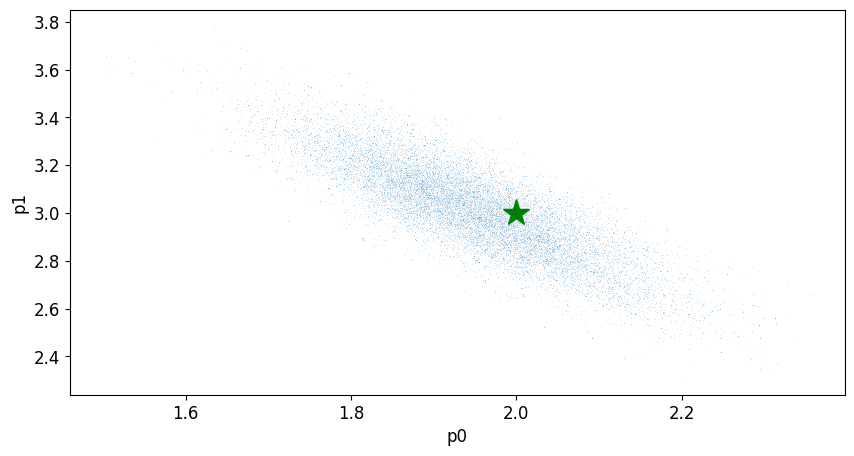

In [45]:
plot(chain['p0'], chain['p1'], ',', alpha=0.1)
plot(2,3,'g*', label='True Value',ms=20)
xlabel('p0')
ylabel('p1')

Nous voyons que la distribution des points contient bien la vraie valeur. Maintenant, nous voulons interpréter la chaîne MCMC en termes d'intervalles de confiance.

Première chose importante ici : la notion de marginalisation. On dit qu'on marginalise une variable lorsque l'on a une probabilité qui dépend de nombreuses variables et que l'on regarde la probabilité réduite à un sous-ensemble des variables en intégrant sur les variables marginalisées. Ici, nous marginalisons sur $b$ :
$$P(a) = \int P(a,b) \mathrm{d}b$$
Avec une approche fréquentiste des probabilités (typiquement lors de l'utilisation de Minuit), une telle marginalisation implique une procédure très complexe pour calculer explicitement cette intégrale.

Au contraire, avec une approche bayésienne MCMC, l'intégration sur la dimension $b$ se réduit simplement à tracer l'histogramme de toutes les dimensions de la chaîne sauf $b$. Nous pouvons facilement montrer les probabilités individuelles de toutes nos variables lorsqu'elles sont marginalisées sur toutes les autres, et nous pouvons calculer les intervalles de confiance pour chaque variable individuelle marginalisée sur les autres.

Dans notre exemple d'ajustement de droite :

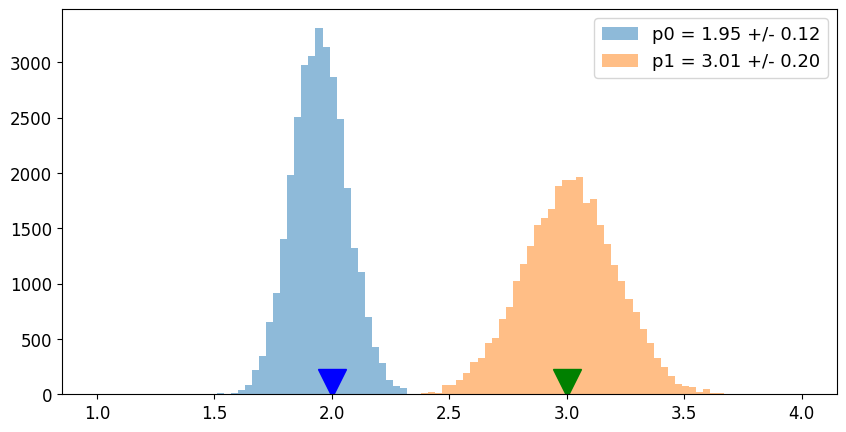

In [46]:
mp0 = np.mean(chain['p0'])
mp1 = np.mean(chain['p1'])
sp0 = np.std(chain['p0'])
sp1 = np.std(chain['p1'])
aa=hist(chain['p0'], bins=100, range=[1,4], alpha=0.5, label='p0 = {0:3.2f} +/- {1:3.2f}'.format(mp0, sp0))
bb=hist(chain['p1'], bins=100, range=[1,4], alpha=0.5, label='p1 = {0:3.2f} +/- {1:3.2f}'.format(mp1, sp1))
plot(2,100,'bv',ms=20)
plot(3,100,'gv',ms=20)
legend(fontsize=13)

Les triangles bleus et verts montrent les vraies valeurs.

En ce qui concerne les intervalles de confiance N-dimensionnels, ils sont bien sûr impossibles à dessiner sur un écran, nous montrons donc généralement des graphiques 2D de toutes les paires de variables, en marginalisant sur les autres. Dans notre exemple, il n'y a qu'un seul graphique 2D que nous montrons à travers un histogramme 2D (nous superposons en rouge les vraies valeurs d'entrée) :

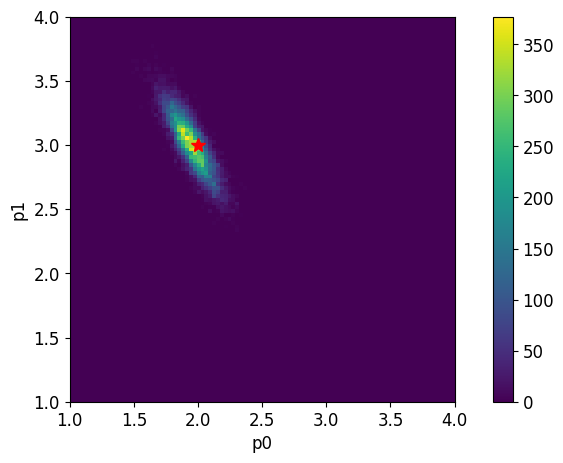

In [47]:
im2d = hist2d(chain['p0'], chain['p1'], bins=100,
              range=[[1,4],[1,4]])
imshow(im2d[0].T, interpolation='nearest', origin='lower',
       extent = (0,5,0,5))
colorbar()
xlabel('p0')
ylabel('p1')
plot(2,3,'r*', label='True Value',ms=10)


Finalement, les résultats MCMC sont souvent représentés sous forme d'une sorte de matrice de graphiques avec tous les posteriors 2-D et 1-D lissés pour un aspect agréable. Les histogrammes 2-D sont également remplacés par des contours 2-D qui montrent différents intervalles de confiance (par exemple, les niveaux de confiance à 68 et 95 %). La fonction `matrixplot()` dans cosmolib.py fait cela pour vous !

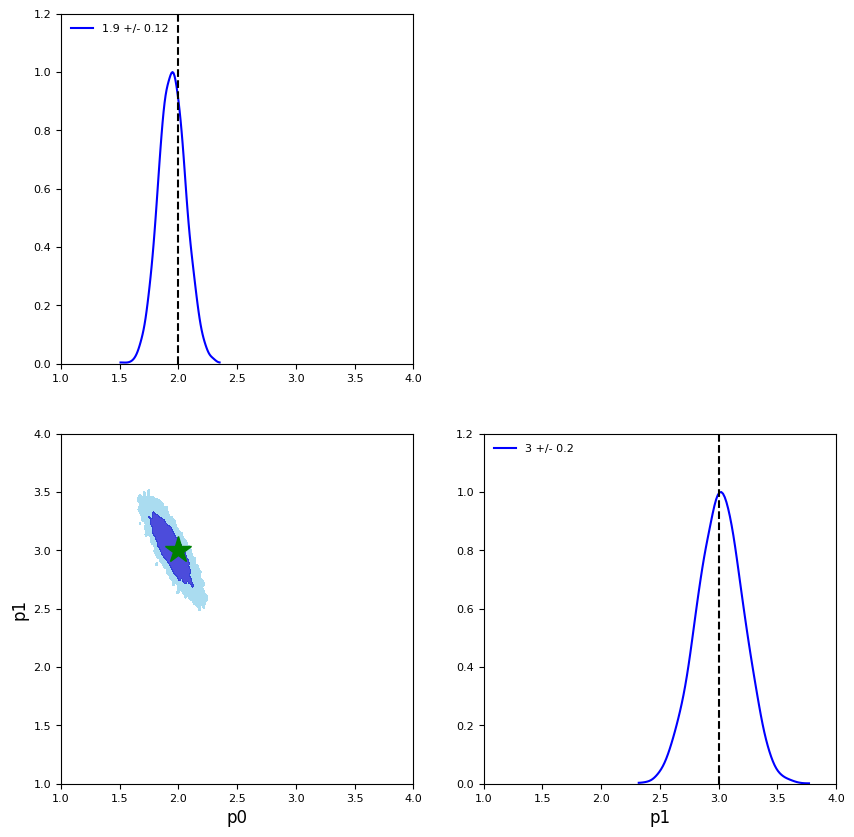

In [48]:
rc('figure',figsize=(10,10))
sm = 1.5   #smoothing parameter - to be adjusted not to change the shape
cs.matrixplot(chain, ['p0', 'p1'], 'blue', sm,
              limits = [[1,4], [1,4]], labels=['p0','p1'])

#### Overplot the True Values
subplot(2,2,1)
plot([2,2], [0,2], 'k--')
subplot(2,2,4)
plot([3,3], [0,2], 'k--')
subplot(2,2,3)
plot(2,3,'g*', label='True Value',ms=20)


En relançant le dessin du bruit pour la droite, et en relançant le reste, vous verrez comment différentes réalisations se déplacent par rapport aux points réels.

#### Un peu plus avancé :
Nous aurions pu spécifier un modèle plus général pour l'ajustement, par exemple un polynôme du 4e ordre, et ajuster uniquement les deux premiers paramètres. Cela peut être facilement réalisé avec les fonctions MCMC fournies en utilisant le paramètre `fixpars`.

[2, 3, 4, 5]
[2, 3, 4, 5]
Ndim init: 6
New ndim: 2
Len(pos): (32, 6)
len(fixepars): 4
New len(pos): (32, 2)
Burning


100%|██████████| 333/333 [00:00<00:00, 946.98it/s]


Sampling


100%|██████████| 1000/1000 [00:01<00:00, 912.93it/s]


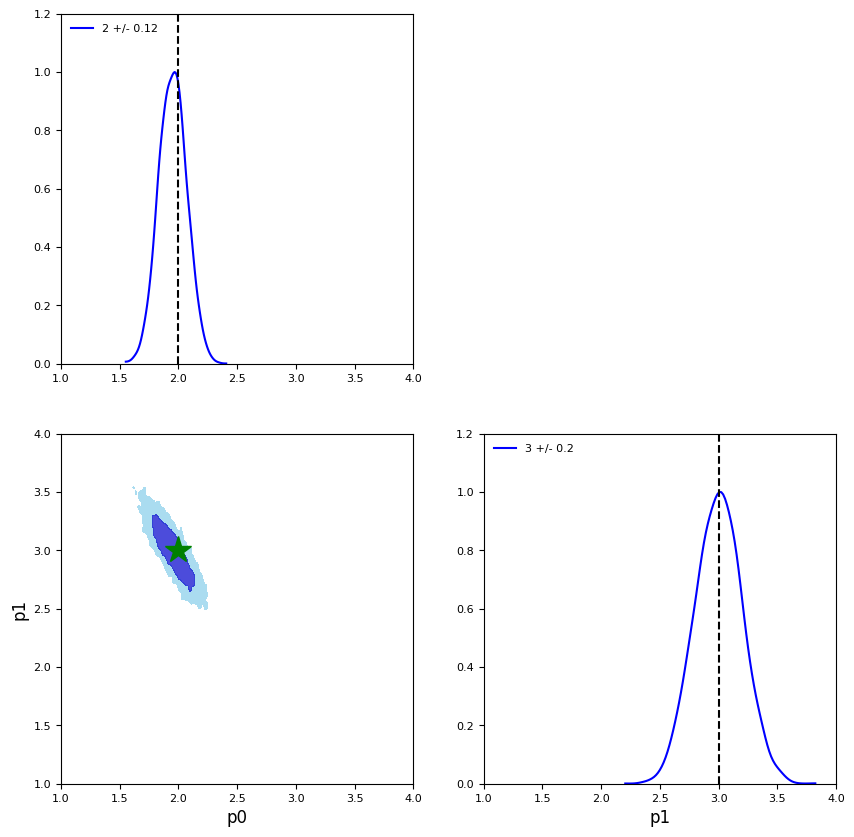

In [49]:
def fonction(x, par):
    return par[0] + par[1]*x + par[2]*x**2 + par[3]*x**3 + par[4]*x**4

data = cs.Data(x, y, sigma_y, fonction)
guess = np.zeros(6)
chain = data.run_mcmc(guess, nbmc=1000, allvariables=['p0', 'p1', 'p2', 'p3', 'p4', 'p5'],
                   fixpars=[2,3,4,5])

sm = 1.5   #smoothing parameter - to be adjusted not to change the shape
cs.matrixplot(chain, ['p0', 'p1'], 'blue', sm,
              limits = [[1,4], [1,4]], labels=['p0','p1'])

#### Overplot the True Values
subplot(2,2,1)
plot([2,2], [0,2], 'k--')
subplot(2,2,4)
plot([3,3], [0,2], 'k--')
subplot(2,2,3)
plot(2,3,'g*', label='True Value',ms=20)

Ici, nous n'avons rien spécifié concernant la valeur des paramètres non ajustés, donc le code les configure automatiquement à zéro. Nous aurions pu décider de les fixer à une autre valeur via le paramètre `guess`. Les paramètres fixés ne seraient pas modifiés tandis que les paramètres libres seraient échantillonnés.

#### MCMC avec les SNIa
***Question 6:*** Effectuez maintenant l'ajustement MCMC sur les données des supernovae pour le modèle $\Lambda CDM$ avec les variables $\Omega_m$ et $\Omega_\Lambda$ (nous ne tiendrons pas compte de $w$ et rappelons que les supernovae ne contraignent pas la constante de Hubble, donc ces deux valeurs ne doivent pas être ajustées mais fixées respectivement à -1 et 0,7 comme valeurs fiduciales).
Ensuite, affichez le graphique matriciel des contours.

/content/cosmolib.py:28: RuntimeWarning: invalid value encountered in sqrt
  e_z=np.sqrt(omegak*(1+z)**2+omegaxz+omegam*(1+z)**3)


[0, 3]
[0, 3]
Ndim init: 4
New ndim: 2
Len(pos): (32, 4)
len(fixepars): 2
New len(pos): (32, 2)
Burning


100%|██████████| 333/333 [00:04<00:00, 72.16it/s]


Sampling


100%|██████████| 1000/1000 [00:13<00:00, 75.84it/s]


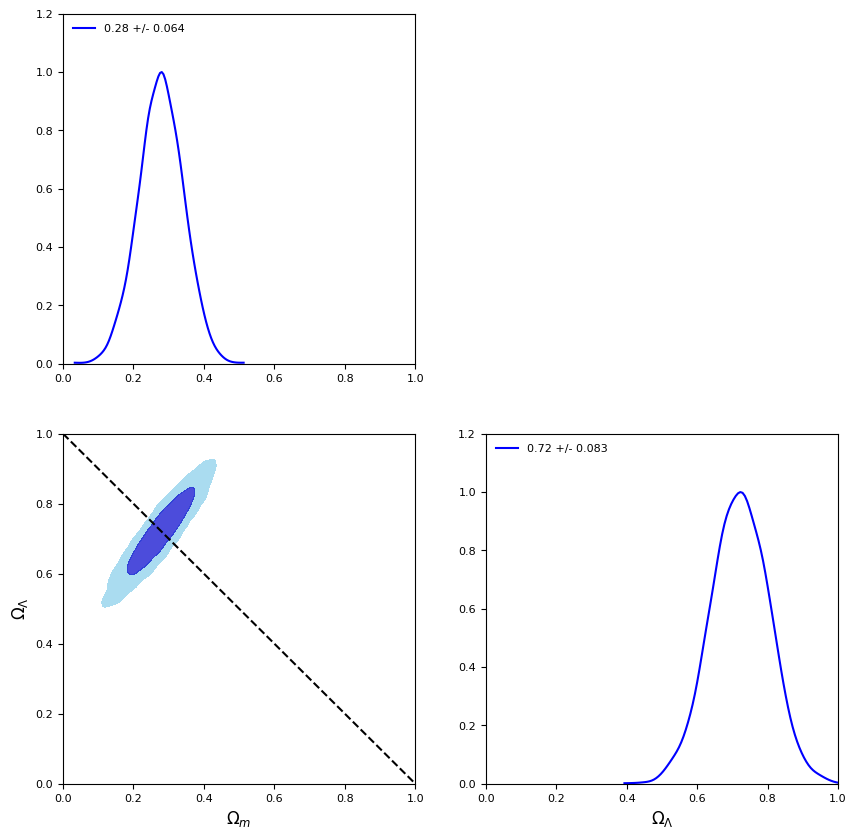

In [50]:
def newmusn(x, pars):
    cosmo = {'h':pars[0], 'omega_M_0':pars[1],
             'omega_lambda_0':pars[2], 'w0':pars[3]}
    val = cs.musn1a(x, cosmo)
    val[isnan(val)] = -1e30
    return val

data = cs.Data(zsn, musn, dmusn, newmusn)
guess = np.array([0.7, 0.3, 0.7, -1])
chainomol = data.run_mcmc(guess, nbmc=1000, allvariables=['h','om', 'ol','w'],
                        fixpars=[0,3])

sm = 3
cs.matrixplot(chainomol, ['om', 'ol'], 'blue', sm,
              limits = [[0,1], [0,1.]],
              labels=['$\Omega_m$','$\Omega_\Lambda$'])
subplot(2,2,3)
plot(linspace(0,1,10),1-linspace(0,1,10),'k--')

Vous venez de remporter le prix Nobel de physique 2011 !
https://www.nobelprize.org/prizes/physics/2011/summary/

Juste un peu en retard...

# Aller plus loin

Pour ceux d'entre vous désireux d'approfondir, il est intéressant d'étudier les contraintes imposées par les données des supernovae de type Ia (SNIa) sur l'équation d'état de l'énergie sombre \(w_0\). Pour ce faire, vous pouvez d'abord explorer avec une méthode MCMC les trois paramètres conjointement (\(\Omega_m, \Omega_\Lambda, w_0\)), mais vous réaliserez rapidement à quel point ils sont dégénérés les uns avec les autres en utilisant uniquement les données SNIa. C'est pourquoi l'ajout d'autres sondes comme les oscillations acoustiques baryoniques et le fond diffus cosmologique est si puissant : cela brise ces dégénérescences car ces sondes sont sensibles de manière différente aux paramètres cosmologiques par rapport aux SNIa. Une façon plus simple d'étudier cela est d'explorer seulement \((\Omega_m, w_0)\) tout en forçant la courbure à être nulle (comme suggéré par les observations du CMB seules ainsi que préférée d'un point de vue théorique) à travers \(\Omega_\Lambda = 1-\Omega_m\). Vous verrez donc que les données SNIa sont cohérentes avec \(w_0=-1\), c'est-à-dire une simple constante cosmologique.

Vous irez beaucoup plus loin pendant la semaine d'intégration en combinant différentes sondes cosmologiques et en brisant ces dégénérescences de manière rigoureuse.